In [9]:
import sys
import os
from pathlib import Path
import pandas as pd
import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
processed_series_path = Path(parent_dir) / 'processed_series'
generated_series_path = Path(parent_dir) / 'generated_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
# from models.ICL import MultiResolutionPDF

def BT_mean_loss(processed_dict, temperature = 1):
    full_series = processed_dict['full_series']
    rescaled_true_mean_arr = processed_dict['rescaled_true_mean_arr']
    rescaled_true_sigma_arr = processed_dict['rescaled_true_sigma_arr']
    llama_size = processed_dict['llama_size']
    mode = processed_dict['mode']
    refine_depth = processed_dict['refine_depth']
    random_seed = processed_dict['random_seed']
    PDF_list = processed_dict['PDF_list']
    time_series = processed_dict['time_series']
    prec = processed_dict['prec']
    for PDF in PDF_list:
        if temperature != 1:
            PDF.rescale_temperature(temperature)
    ### Calculate true discretized distribution: PDF_list_true
    ### Compute discretized BT and KL loss

    PDF_true_list = copy.deepcopy(PDF_list)
    discrete_BT_loss = []
    # discrete_KL_loss = []
    for PDF, PDF_true, true_mean, true_sigma in zip(PDF_list, PDF_true_list, rescaled_true_mean_arr, rescaled_true_sigma_arr):
        def cdf(x):
            return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))

        PDF_true.discretize(cdf, mode = "cdf")
        PDF_true.compute_stats()
        discrete_BT_loss += [PDF_true.BT_dist(PDF)]    
        # discrete_KL_loss += [PDF_true.KL_div(PDF)]

    discrete_BT_loss = np.array(discrete_BT_loss)
    # discrete_KL_loss = np.array(discrete_KL_loss)

    ### Extract statistics from MultiResolutionPDF

    mean_arr = []
    mode_arr = []
    sigma_arr = []
    moment_3_arr = []
    moment_4_arr = []

    num_commas = full_series.count(',')
    for comma_idx in range(num_commas):
        PDF_list[comma_idx].compute_stats()
        mean, mode, sigma = PDF_list[comma_idx].mean, PDF_list[comma_idx].mode, PDF_list[comma_idx].sigma 
        moment_3 = PDF_list[comma_idx].compute_moment(3)
        moment_4 = PDF_list[comma_idx].compute_moment(4)
        
        mean_arr.append(mean)
        mode_arr.append(mode)
        sigma_arr.append(sigma)
        moment_3_arr.append(moment_3)
        moment_4_arr.append(moment_4)

    # Convert lists to numpy arrays
    mean_arr = np.array(mean_arr)
    mode_arr = np.array(mode_arr)
    sigma_arr = np.array(sigma_arr)
    moment_3_arr = np.array(moment_3_arr)
    moment_4_arr = np.array(moment_4_arr)

    error_mean = np.abs(rescaled_true_mean_arr - mean_arr)
    
    window_size = 20
    xlog = 1
    ylog = 1


    top_hat_kernel = np.ones(window_size) / window_size
    gaussian_kernel = norm.pdf(np.arange(window_size), loc=window_size // 2, scale=window_size / 6)
    # kernel = gaussian_kernel
    kernel = top_hat_kernel        
    averaged_error_mean = np.convolve(error_mean, kernel, mode='valid')
    averaged_discrete_BT_loss = np.convolve(discrete_BT_loss, kernel, mode='valid')
    x_range = np.arange(window_size//2, len(discrete_BT_loss) - window_size//2 + 1)
    return(x_range, averaged_error_mean, averaged_discrete_BT_loss)


def experiment_plotter(series_name, xlog, ylog, plot_mean, processed_series):
    BT_loss_list = []
    mean_loss_list = []

    fig, ax1 = plt.subplots(figsize=(8, 3))
    axs = [ax1]
    if plot_mean:
        ax2 = ax1.twinx()
        axs += [ax2]
        
    if xlog:
        for ax in axs:
            ax.set_xscale('log')
        
    if ylog:
        for ax in axs:
            ax.set_yscale('log')    
        
    for series_dict in processed_series[series_name]:
        if series_dict['prec'] == 3:
            continue
        plot_title = f"random_seed: {series_dict['random_seed']}, prec: {series_dict['prec']}, refine_depth: {series_dict['refine_depth']}, mode: {series_dict['mode']}"
        print(plot_title)
        x_range, mean_loss, BT_loss = BT_mean_loss(series_dict, temperature = 1)
        BT_loss_list += [BT_loss]
        mean_loss_list += [mean_loss]
        
        ax1.plot(x_range, BT_loss, linewidth=2, c='black', alpha = 0.1)
               
        if plot_mean:
            ax2.spines['right'].set_color('blue')
            ax2.yaxis.label.set_color('blue')
            ax2.tick_params(axis='y', colors='blue')  
            ax2.plot(x_range, mean_loss, linewidth=2, c='blue', alpha = 0.1)
            ax2.set_ylabel("Squared Deviation from the Mean")


    avg_BT_loss = np.mean(BT_loss_list, axis=0)
    avg_mean_loss = np.mean(mean_loss_list, axis=0)
    ax1.plot(x_range, avg_BT_loss , linewidth=2, c='black', alpha = 0.7)
    ax1.set_ylabel("Bhattacharyya Distance")
    ax1.set_xlabel("Number of States Observed In-context")
    if plot_mean:
        ax1.plot(x_range, avg_mean_loss , linewidth=2, c='blue', alpha = 0.7)


    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title(f"in-context loss for learning {series_name.replace('_', ' ')}")
    plt.show()

In [10]:
### load all series
processed_series_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
generated_series_files = sorted([path for path in generated_series_path.iterdir()], key=lambda x: x.name)
  
all_series = {}
processed_series = {}
for idx, file in enumerate(generated_series_files):
    series_name = file.name.rsplit('_', 1)[0]
    if series_name not in all_series:
        all_series[series_name] = []
        processed_series[series_name] = []
    series_dict = pickle.load(file.open('rb'))
    series_dict['series_name'] = file.name[:-4]
    corresponding_processed_file = next((processed_file for processed_file in processed_series_files if processed_file.name == file.name), None)
    if corresponding_processed_file is not None:
        processed_dict = pickle.load(corresponding_processed_file.open('rb'))
        series_dict['processed?'] = "yes" 
        processed_series[series_name] += [processed_dict]
    else:
        series_dict['processed?'] = 'no'
    all_series[series_name] += [series_dict]
    

# Create a DataFrame to store the series data
series_df = pd.DataFrame(columns=['Name', 'Random Seed', 'Precision', 'Mode', 'processed?'])

for key, series_list in all_series.items():
    if key == 'markov_chain':
        continue
    for series in series_list:
        # Append the series data to the DataFrame
        new_row = pd.DataFrame({'Name': [series['series_name']], 
                                'Random Seed': [series['random_seed']], 
                                'Precision': [series['prec']], 
                                'Mode': [series['mode']],
                                'processed?': [series['processed?']]})
        # Explicitly cast to bool dtype to avoid FutureWarning
        series_df = pd.concat([series_df, new_row], ignore_index=True)

# Print the DataFrame without the index
print(series_df.to_string(index=False))


                       Name Random Seed Precision     Mode processed?
          brownian_motion_0           5         3 neighbor        yes
          brownian_motion_1           6         3 neighbor        yes
         brownian_motion_10          13         3 neighbor        yes
         brownian_motion_11          14         3 neighbor         no
         brownian_motion_12           7         2      all        yes
         brownian_motion_13           8         2      all        yes
         brownian_motion_14           9         2      all        yes
         brownian_motion_15          10         2      all        yes
         brownian_motion_16          11         2      all        yes
         brownian_motion_17          12         2      all        yes
         brownian_motion_18          13         2      all        yes
         brownian_motion_19          14         2      all        yes
          brownian_motion_2           5         2      all        yes
          brownian_m

random_seed: 54, prec: 2, refine_depth: 1, mode: all
random_seed: 3, prec: 2, refine_depth: 1, mode: all
random_seed: 4, prec: 2, refine_depth: 1, mode: all


/tmp/ipykernel_4704/2641494844.py:42: RuntimeWarning: divide by zero encountered in divide
  return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))


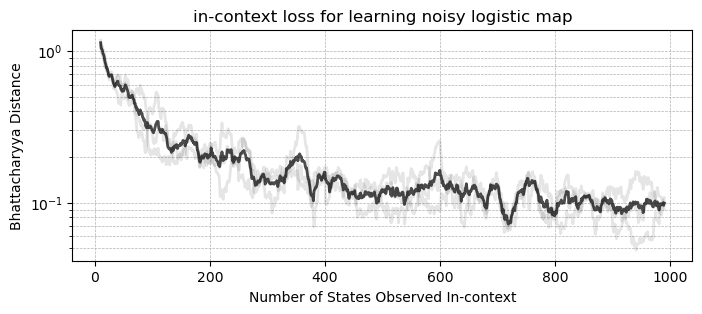

In [23]:
experiment_plotter(series_name = 'noisy_logistic_map', 
                   xlog = 0, 
                   ylog = 1, 
                   plot_mean = 0, 
                   processed_series=processed_series)

random_seed: 0, prec: 2, refine_depth: 1, mode: all
random_seed: 1, prec: 2, refine_depth: 1, mode: all


/tmp/ipykernel_4704/2641494844.py:42: RuntimeWarning: divide by zero encountered in divide
  return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))


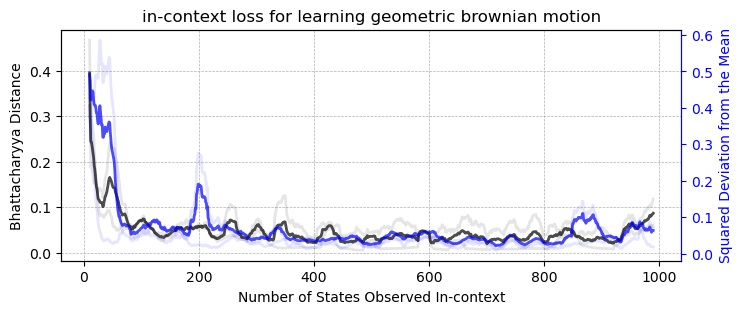

In [12]:
experiment_plotter(series_name = 'geometric_brownian_motion',
                   xlog = 0, 
                   ylog = 0, 
                   plot_mean = 1,
                   processed_series=processed_series)

random_seed: 0, prec: 2, refine_depth: 1, mode: all
random_seed: 1, prec: 2, refine_depth: 1, mode: all
random_seed: 2, prec: 2, refine_depth: 1, mode: all


/tmp/ipykernel_4704/2641494844.py:42: RuntimeWarning: divide by zero encountered in divide
  return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))
/tmp/ipykernel_4704/2641494844.py:42: RuntimeWarning: invalid value encountered in divide
  return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))


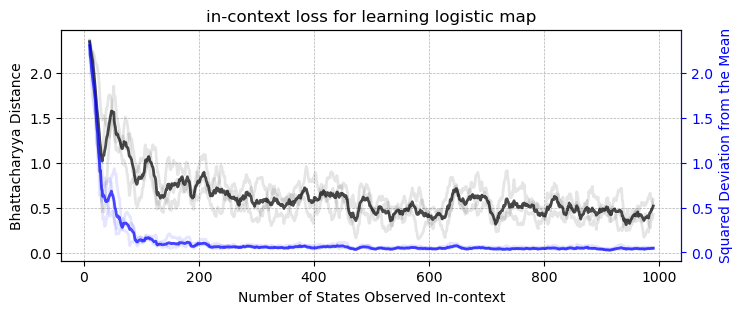

In [13]:
experiment_plotter(series_name = 'logistic_map',
                   xlog = 0, 
                   ylog = 0, 
                   plot_mean = 1,
                   processed_series=processed_series)

random_seed: 0, prec: 2, refine_depth: 1, mode: all
random_seed: 1, prec: 2, refine_depth: 1, mode: all


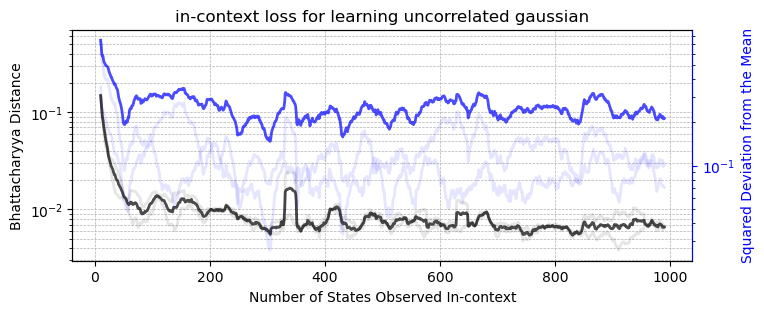

In [20]:
experiment_plotter(series_name = 'uncorrelated_gaussian',
                   xlog = 0, 
                   ylog = 1, 
                   plot_mean = 1,
                   processed_series=processed_series)

random_seed: 7, prec: 2, refine_depth: 1, mode: all
random_seed: 8, prec: 2, refine_depth: 1, mode: all
random_seed: 9, prec: 2, refine_depth: 1, mode: all


/tmp/ipykernel_4704/2641494844.py:42: RuntimeWarning: divide by zero encountered in divide
  return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))


random_seed: 10, prec: 2, refine_depth: 1, mode: all
random_seed: 11, prec: 2, refine_depth: 1, mode: all
random_seed: 12, prec: 2, refine_depth: 1, mode: all
random_seed: 13, prec: 2, refine_depth: 1, mode: all
random_seed: 14, prec: 2, refine_depth: 1, mode: all
random_seed: 5, prec: 2, refine_depth: 1, mode: all
random_seed: 6, prec: 2, refine_depth: 1, mode: all


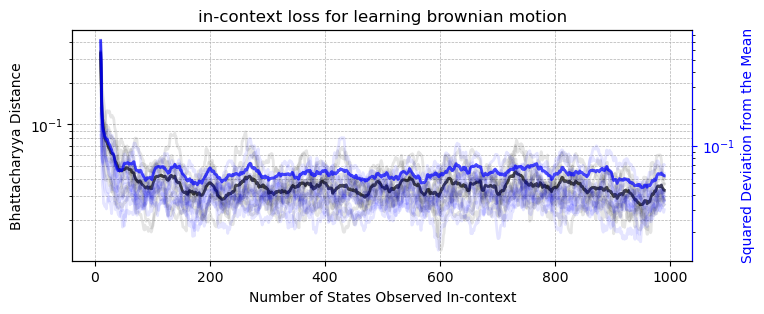

In [21]:
experiment_plotter(series_name = 'brownian_motion',
                   xlog = 0, 
                   ylog = 1, 
                   plot_mean = 1,
                   processed_series=processed_series)